In [9]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
from ast import literal_eval
from tqdm import tqdm

# Create first cell for data loading
def load_and_preprocess_data(file_path):
    # Load data
    print("Loading data...")
    data = pd.read_csv(file_path)
    
    # Convert sequences
    print("Converting sequences...")
    data['sequence'] = data['sequence'].apply(literal_eval)
    
    # Get max length
    max_len = max(len(seq) for seq in data['sequence'])
    
    # Pad sequences
    print("Padding sequences...")
    def pad_sequence(seq):
        return np.pad([int(x) for x in seq], 
                     (0, max_len - len(seq)), 
                     'constant')
    
    X = np.array([pad_sequence(seq) for seq in tqdm(data['sequence'])])
    
    # Convert labels
    y = pd.get_dummies(data['label']).values
    
    # Normalize to [0,1]
    X = (X - X.min()) / (X.max() - X.min())
    
    # Convert to tensors
    X_tensor = torch.FloatTensor(X).unsqueeze(1)
    y_tensor = torch.FloatTensor(y)
    
    return X_tensor, y_tensor

# Test the function
X_tensor, y_tensor = load_and_preprocess_data('adfa_ld_processed.csv')
print(f"\nData loaded successfully!")
print(f"X shape: {X_tensor.shape}")
print(f"y shape: {y_tensor.shape}")
print(f"X range: [{X_tensor.min():.2f}, {X_tensor.max():.2f}]")

Loading data...
Converting sequences...
Padding sequences...


100%|██████████| 1579/1579 [00:00<00:00, 10716.48it/s]



Data loaded successfully!
X shape: torch.Size([1579, 1, 2948])
y shape: torch.Size([1579, 2])
X range: [0.00, 1.00]


Normalization Check:
Minimum value: 0.000000
Maximum value: 1.000000
Mean value: 0.046142


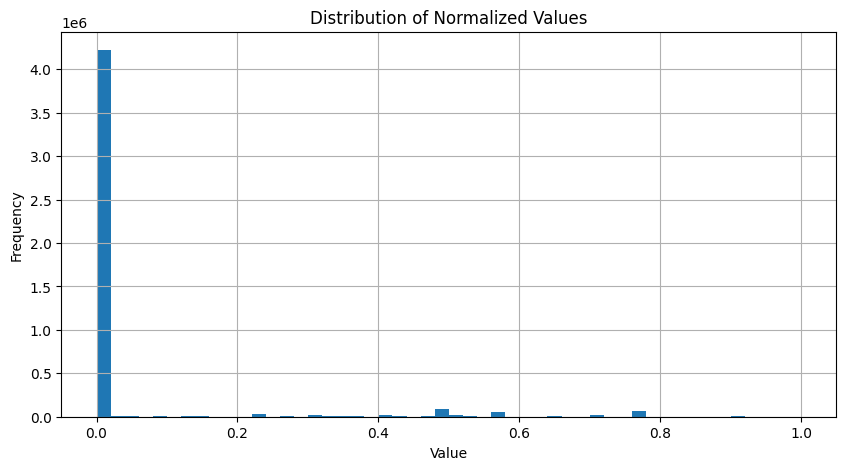

In [10]:
import matplotlib.pyplot as plt

# Check normalization range
print("Normalization Check:")
print(f"Minimum value: {X_tensor.min().item():.6f}")
print(f"Maximum value: {X_tensor.max().item():.6f}")
print(f"Mean value: {X_tensor.mean().item():.6f}")

# Create histogram to visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(X_tensor.numpy().flatten(), bins=50)
plt.title('Distribution of Normalized Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Additional checks
assert X_tensor.min() >= 0, "Values below 0 found"
assert X_tensor.max() <= 1, "Values above 1 found"

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.model_selection import train_test_split

# 1. Create DataLoader
def create_dataloader(X_tensor, y_tensor, batch_size=32):
    dataset = data.TensorDataset(X_tensor, y_tensor)
    dataloader = data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )
    return dataloader

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor.squeeze(1), y_tensor, 
    test_size=0.2, 
    random_state=42
)

# 3. Create models
class Generator(nn.Module):
    def __init__(self, latent_dim, sequence_length):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, sequence_length),
            nn.Sigmoid()  # Ensure output is [0,1]
        )
    
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, sequence_length):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(sequence_length, 2048),
            nn.LayerNorm(2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            ResidualBlock(2048),
            nn.Linear(2048, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            ResidualBlock(1024),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            ResidualBlock(512),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
        # Weight initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        return self.main(x)

# 4. Initialize models
sequence_length = X_tensor.shape[2]
latent_dim = 100

generator = Generator(latent_dim, sequence_length)
discriminator = Discriminator(sequence_length)

# 5. Create dataloaders
train_loader = create_dataloader(X_train, y_train)
test_loader = create_dataloader(X_test, y_test)

print("Models initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters())}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters())}")

Models initialized successfully!
Generator parameters: 3601796
Discriminator parameters: 3545089


In [12]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Training Configuration
config = {
    'n_epochs': 100,
    'batch_size': 32,
    'lr': 0.0002,
    'beta1': 0.5,
    'latent_dim': 100,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

# Move models to device
generator = generator.to(config['device'])
discriminator = discriminator.to(config['device'])

# Setup optimizers
g_optimizer = Adam(generator.parameters(), lr=config['lr'], betas=(config['beta1'], 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=config['lr'], betas=(config['beta1'], 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Lists to store metrics
d_losses = []
g_losses = []

print(f"Training setup complete on device: {config['device']}")

Training setup complete on device: cpu


In [16]:
import matplotlib.pyplot as plt

# Plot training progress
def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10,5))
    plt.plot(d_losses, label='Discriminator Loss', alpha=0.8)
    plt.plot(g_losses, label='Generator Loss', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

# Modify learning rate
config['lr'] = 0.0001  # Reduce learning rate

# Add gradient clipping
torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)

# Update optimizers
g_optimizer = Adam(generator.parameters(), lr=config['lr'], betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=config['lr'], betas=(0.5, 0.999))

IndentationError: expected an indented block (1216153583.py, line 20)

In [17]:
import os
from datetime import datetime
from tqdm.auto import tqdm  # Changed to tqdm.auto

# Create folder for model checkpoints
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = f'model_checkpoints_{timestamp}'
os.makedirs(save_dir, exist_ok=True)

def train_gan():
    # Initialize loss lists
    d_losses = []
    g_losses = []
    
    for epoch in range(config['n_epochs']):
        d_epoch_loss = 0
        g_epoch_loss = 0
        
        # Modified progress bar
        for batch_idx, (real_data, _) in enumerate(train_loader):
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{config["n_epochs"]}] Batch [{batch_idx}/{len(train_loader)}]', end='\r')
                
            batch_size = real_data.size(0)
            real_data = real_data.to(config['device'])

            # Ground truths
            valid = torch.ones(batch_size, 1).to(config['device'])
            fake = torch.zeros(batch_size, 1).to(config['device'])

            # Train Generator
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, config['latent_dim']).to(config['device'])
            generated_data = generator(z)
            g_loss = adversarial_loss(discriminator(generated_data), valid)
            g_loss.backward()
            g_optimizer.step()

            # Train Discriminator
            d_optimizer.zero_grad()
            real_loss = adversarial_loss(discriminator(real_data), valid)
            fake_loss = adversarial_loss(discriminator(generated_data.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            d_optimizer.step()

            # Update losses
            d_epoch_loss += d_loss.item()
            g_epoch_loss += g_loss.item()

        # Print epoch results
        print(f'\nEpoch [{epoch+1}/{config["n_epochs"]}] D_loss: {d_epoch_loss/len(train_loader):.4f} G_loss: {g_epoch_loss/len(train_loader):.4f}')

        # Save epoch losses
        d_losses.append(d_epoch_loss/len(train_loader))
        g_losses.append(g_epoch_loss/len(train_loader))
        
        # Save model checkpoint every 1000 epochs
        if (epoch + 1) % 1000 == 0:
            checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pt')
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': g_epoch_loss/len(train_loader),
                'd_loss': d_epoch_loss/len(train_loader)
            }, checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")
    
    return d_losses, g_losses

# Start training
d_losses, g_losses = train_gan()

Epoch [1/100] Batch [30/40]
Epoch [1/100] D_loss: 0.1648 G_loss: 19.5993
Epoch [2/100] Batch [30/40]
Epoch [2/100] D_loss: 0.1840 G_loss: 18.9878
Epoch [3/100] Batch [30/40]
Epoch [3/100] D_loss: 0.1666 G_loss: 18.5643
Epoch [4/100] Batch [30/40]
Epoch [4/100] D_loss: 0.1526 G_loss: 18.1249
Epoch [5/100] Batch [30/40]
Epoch [5/100] D_loss: 0.1523 G_loss: 18.7198
Epoch [6/100] Batch [30/40]
Epoch [6/100] D_loss: 0.1598 G_loss: 18.4655
Epoch [7/100] Batch [30/40]
Epoch [7/100] D_loss: 0.1476 G_loss: 18.4071
Epoch [8/100] Batch [30/40]
Epoch [8/100] D_loss: 0.1460 G_loss: 18.6833
Epoch [9/100] Batch [30/40]
Epoch [9/100] D_loss: 0.1554 G_loss: 17.7874
Epoch [10/100] Batch [30/40]
Epoch [10/100] D_loss: 0.1433 G_loss: 17.6819
Epoch [11/100] Batch [30/40]
Epoch [11/100] D_loss: 0.1391 G_loss: 16.5094
Epoch [12/100] Batch [30/40]
Epoch [12/100] D_loss: 0.1419 G_loss: 17.3514
Epoch [13/100] Batch [30/40]
Epoch [13/100] D_loss: 0.1410 G_loss: 17.4806
Epoch [14/100] Batch [30/40]
Epoch [14/100]

KeyboardInterrupt: 